<img src="../assets/header_notebook.png" />
<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>ESA - Black Sea Deoxygenation Emulator</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
# ----------
# Librairies
# ----------
import os
import sys
import cv2
import dawgz
import wandb
import xarray
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# Dawgz (jobs //)
from dawgz import job, schedule

# -------------------
# Librairies (Custom)
# -------------------
# Adding path to source folder to load custom modules
sys.path.append('../src')
sys.path.append('../src/debs/')
sys.path.insert(1, '../src/debs/')
sys.path.insert(1, '../scripts/')

# Loading libraries
from metrics              import *
from tools                import *
from dataset              import *
from dataloader           import *
from tools                import *
from losses               import *

# -------
# Jupyter
# -------
%matplotlib inline
plt.rcParams.update({'font.size': 13})

# Making sure modules are reloaded when modified
%reload_ext autoreload
%autoreload 2

# Moving to the .py directory
%cd ../src/debs/

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>SCRIPTS</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
# Training a neural network:
%run __training.py --config local

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Playground</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
# -----------------
#    Parameters
# -----------------
#
# Time window
month_starting = 6
month_ending   = 8
year_starting  = 1980
year_ending    = 1980

# Maximum depth observed for oxygen, what is left is masked [m] (Note: To observe only the continental shelf set it to ~200m).
depth_max_oxygen = 400

# ------------------
#  Loading the data
# ------------------
# Loading the different datasets
BSD_dataset = BlackSea_Dataset(year_start  = year_starting,
                               year_end    = year_ending,
                               month_start = month_starting,
                               month_end   = month_ending)

# Loading the days ID (used to give temporal information to the model)
days_ID = BSD_dataset.get_days()

# Loading the different inputs
data_temperature   = BSD_dataset.get_data(variable = "temperature", region = "surface")
data_salinity      = BSD_dataset.get_data(variable = "salinity",    region = "surface")
data_chlorophyll   = BSD_dataset.get_data(variable = "chlorophyll", region = "surface")
data_kshort        = BSD_dataset.get_data(variable = "kshort",      region = "surface")
data_klong         = BSD_dataset.get_data(variable = "klong",       region = "surface")

# Loading the output
data_oxygen        = BSD_dataset.get_data(variable = "oxygen",
                                          region   = "bottom",
                                          depth    = depth_max_oxygen)

# Loading spatial information
bathy = BSD_dataset.get_depth(unit = "meter")
mesh  = BSD_dataset.get_mesh(x = 258, y = 578)

# Loading the black sea masks
bs_mask             = BSD_dataset.get_mask(depth = None)
bs_mask_with_depth  = BSD_dataset.get_mask(depth = depth_max_oxygen)
bs_mask_complete    = get_complete_mask(data_oxygen, bs_mask_with_depth)

# -----------------------
#  Preprocessing the data
# -----------------------
#
# Croping the data to be a multiple of 2
data_temperature   = crop_debug(data_temperature,   factor = 2)
data_salinity      = crop_debug(data_salinity,      factor = 2)
data_chlorophyll   = crop_debug(data_chlorophyll,   factor = 2)
data_kshort        = crop_debug(data_kshort,        factor = 2)
data_klong         = crop_debug(data_klong,         factor = 2)
data_oxygen        = crop_debug(data_oxygen,        factor = 2)
mesh               = crop_debug(mesh,               factor = 2)
bathy              = crop_debug(bathy,              factor = 2)
bs_mask            = crop_debug(bs_mask,            factor = 2)
bs_mask_with_depth = crop_debug(bs_mask_with_depth, factor = 2)
bs_mask_complete   = crop_debug(bs_mask_complete,   factor = 2)

# Creation of the dataloader
BSD_loader = BlackSea_Dataloader(x = [data_temperature],
                                 y = data_oxygen,
                                 t = days_ID,
                              mesh = mesh,
                              mask = bs_mask,
                   mask_with_depth = bs_mask_with_depth,
                        bathymetry = bathy,
                        window_inp = 1,
                        window_out = 1,
                    window_transfo = 1,
                              mode = "regression")

# Retrieving the datasets
ds_train      = BSD_loader.get_dataloader("train")
ds_validation = BSD_loader.get_dataloader("validation")
ds_test       = BSD_loader.get_dataloader("test")

# Extracting the normalized oxygen treshold value
norm_oxy = BSD_loader.get_normalized_deoxygenation_treshold()


In [ ]:
# -------------------------------------------------------
#
#        |
#       / \
#      / _ \                  ESA - PROJECT
#     |.o '.|
#     |'._.'|          BLACK SEA DEOXYGENATION EMULATOR
#     |     |
#   ,'|  |  |`.             BY VICTOR MANGELEER
#  /  |  |  |  \
#  |,-'--|--'-.|                2023-2024
#
#
# -------------------------------------------------------
#
# Documentation
# -------------
# A neural network definition to be used as temporal encoder
#
# Pytorch
import torch.nn as nn


class ENCODER(nn.Sequential):
    r"""A neural network used to encode the temporal information of the data and return weights for the input data"""

    def __init__(self, input_size : int):
        super(ENCODER, self).__init__()

        # Defining the layers
        self.linear_in       = nn.Linear(input_size, 256)
        self.linear_middle_1 = nn.Linear(256,        256)
        self.linear_middle_2 = nn.Linear(256,        128)
        self.linear_middle_3 = nn.Linear(128,         64)
        self.linear_middle_4 = nn.Linear(64,          32)
        self.linear_out      = nn.Linear(32,           1)

        # Defining the activation functions
        self.activation = nn.GELU()

        # Defining the softmax function, i.e. (t, values, day) to (t, values, 1) then (t, weights, 1)
        self.softmax = nn.Softmax(dim = 0)

    def forward(self, x):

        # Applying the layers
        x = self.activation(self.linear_in(x))
        x = self.activation(self.linear_middle_1(x))
        x = self.activation(self.linear_middle_2(x))
        x = self.activation(self.linear_middle_3(x))
        x = self.activation(self.linear_middle_4(x))
        x = self.linear_out(x)

        # Applying the softmax function
        return self.softmax(x)

    def count_parameters(self,):
        r"""Determines the number of trainable parameters in the model"""
        return int(sum(p.numel() for p in self.parameters() if p.requires_grad))

class FCNN(nn.Sequential):
    r"""A fully convolutional neural network"""

    def __init__(self, problem: str, inputs: int, outputs: int, window_transformation: int = 1, kernel_size : int = 3, scaling : int = 1):
        super(FCNN, self).__init__()

        # Initialization
        self.n_in    = inputs
        self.problem = problem
        self.padding = kernel_size // 2

        # Number of output channels, i.e. times 2 because either mean and std for regression or both classes for classification
        self.n_out   = outputs * 2

        # ------ Architecture ------
        #
        # Temporal Encoder
        self.block_encoder = ENCODER(window_transformation)

        # Main Layers
        self.conv_init           = nn.Conv2d(self.n_in    , 256 * scaling, kernel_size, padding = self.padding)
        self.conv_intermediate_1 = nn.Conv2d(256 * scaling, 128 * scaling, kernel_size, padding = self.padding)
        self.conv_intermediate_2 = nn.Conv2d(128 * scaling,  64 * scaling, kernel_size, padding = self.padding)
        self.conv_intermediate_3 = nn.Conv2d( 64 * scaling,  32 * scaling, kernel_size, padding = self.padding)
        self.conv_final          = nn.Conv2d( 32 * scaling,    self.n_out, kernel_size, padding = self.padding)

        # Activation function
        self.activation = nn.GELU()

        # Normalization
        self.normalization_init           = nn.BatchNorm2d(self.conv_init.out_channels)
        self.normalization_intermediate_1 = nn.BatchNorm2d(self.conv_intermediate_1.out_channels)
        self.normalization_intermediate_2 = nn.BatchNorm2d(self.conv_intermediate_2.out_channels)
        self.normalization_intermediate_3 = nn.BatchNorm2d(self.conv_intermediate_3.out_channels)

    def forward(self, x, t):

        # Retrieiving dimensions (Ease of comprehension)
        samples, days, values, variables, x_res, y_res = x.shape

        # ----- Encoding Time -----
        #
        # Applying the encoder
        weights = torch.squeeze(self.block_encoder(t), dim = -1)

        # Applying the weights (except to mesh (dim = 2) and bathymetry (dim = 3))
        for sample in range(samples):
            for value in range(days):
                x[:, value, :, :-3] *= weights[sample, value]

        # Reshaping
        x = x.reshape(samples, days * values * variables, x_res, y_res)

        # ----- Fully Convolutionnal -----
        #
        x = self.normalization_init(self.activation(self.conv_init(x)))
        x = self.normalization_intermediate_1(self.activation(self.conv_intermediate_1(x)))
        x = self.normalization_intermediate_2(self.activation(self.conv_intermediate_2(x)))
        x = self.normalization_intermediate_3(self.activation(self.conv_intermediate_3(x)))
        x = self.conv_final(x)

        # Retrieiving dimensions (Ease of comprehension)
        b, c, x_res, y_res = x.shape

        # Reshaping the output, i.e. (samples, days, values, x, y)
        return x.reshape(b, self.n_out // 2, 2, x_res, y_res)

    def count_parameters(self,):
        r"""Determines the number of trainable parameters in the model"""
        return int(sum(p.numel() for p in self.parameters() if p.requires_grad))


Norm oxy 0.217268240409527
E0 - Loss: 0.2580494284629822


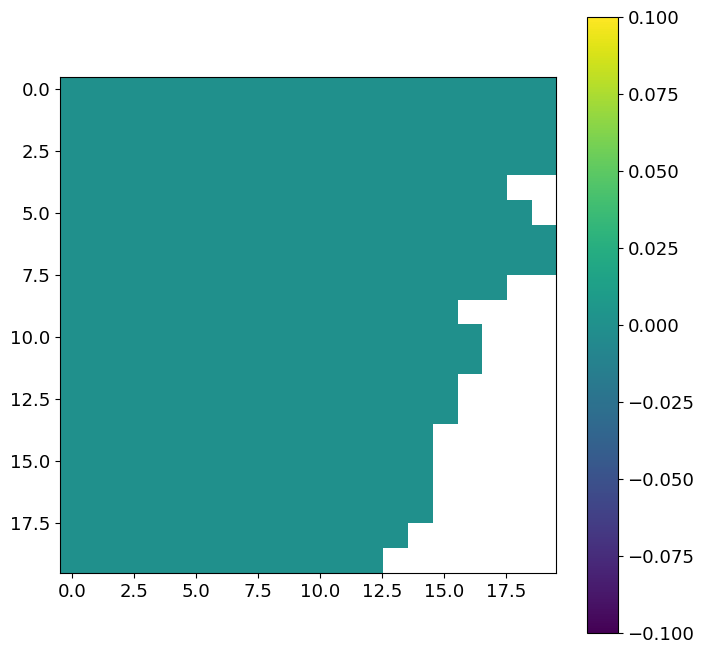

E1 - Loss: 0.04116062447428703


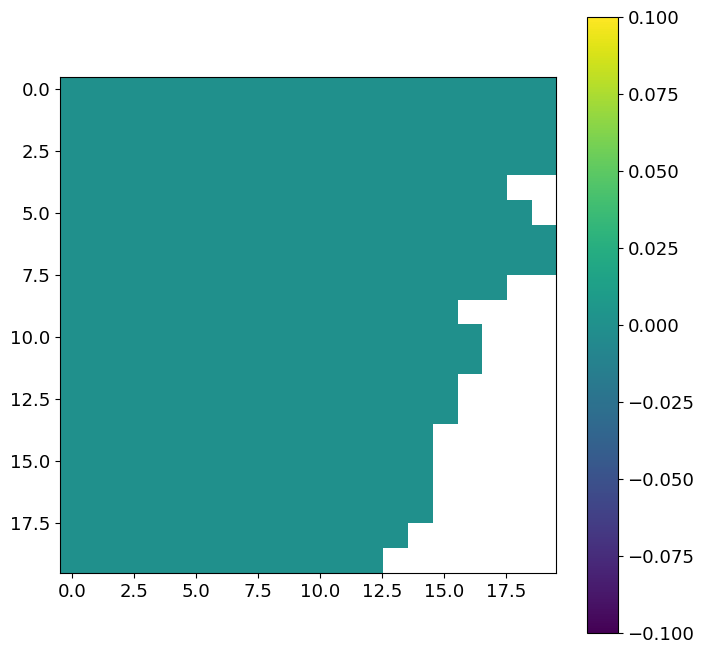

E2 - Loss: -0.24035446345806122


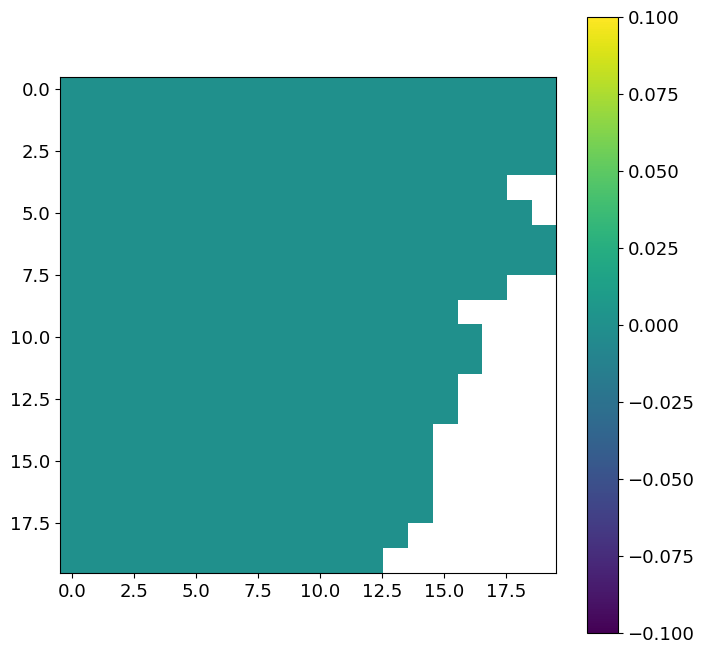

E3 - Loss: -0.4604678750038147


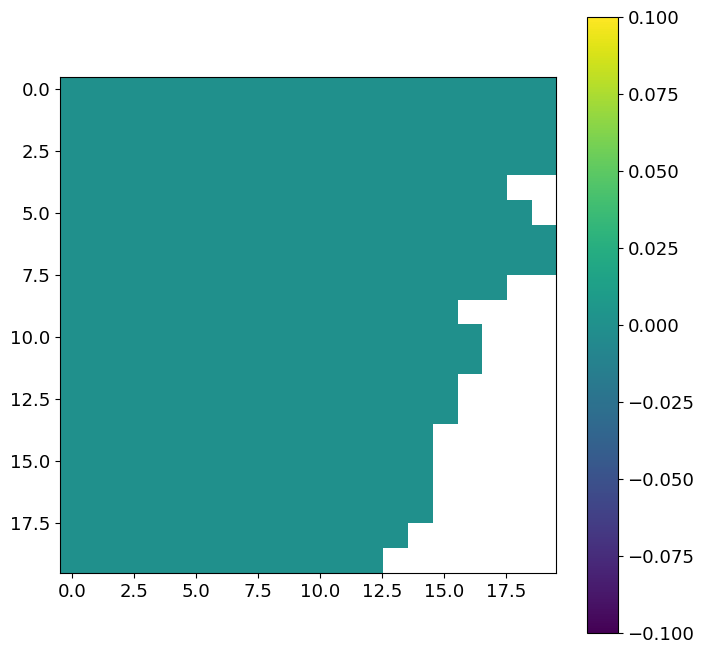

E4 - Loss: -0.5476954579353333


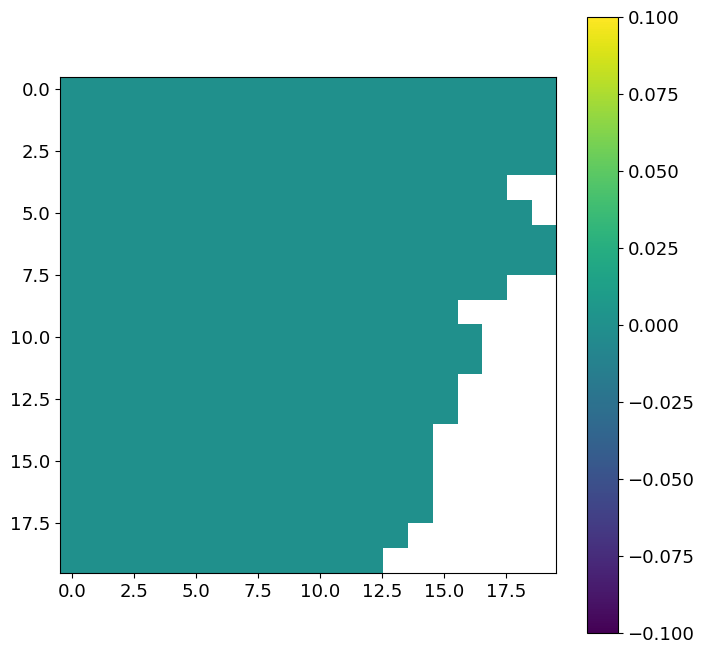

E5 - Loss: -0.620515763759613


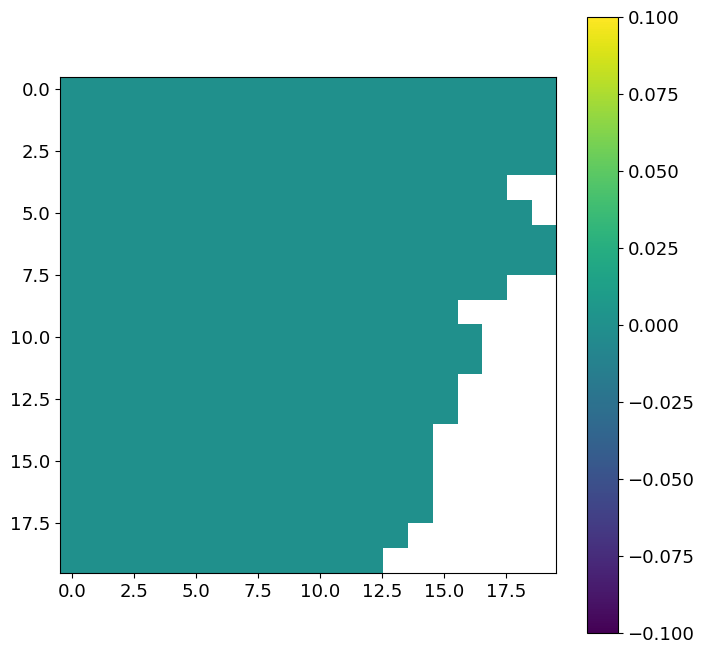

E6 - Loss: -0.7121763825416565


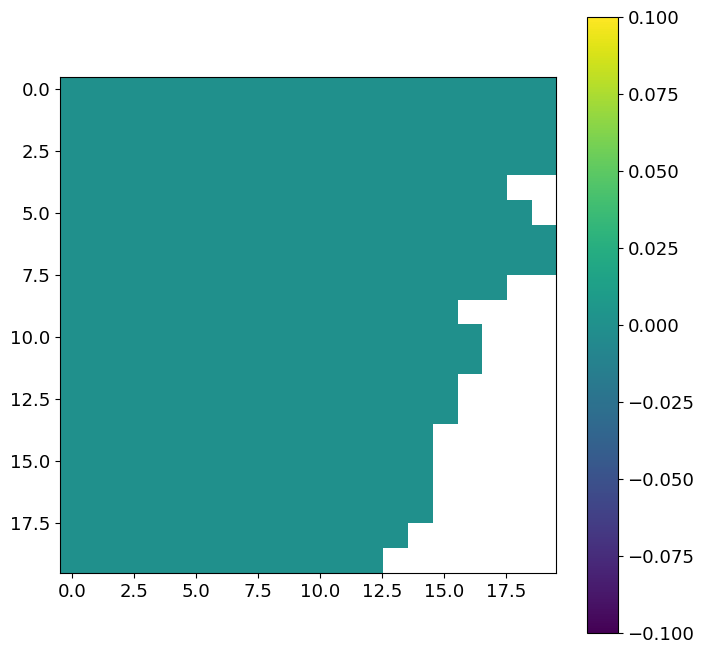

E7 - Loss: -0.7712991833686829


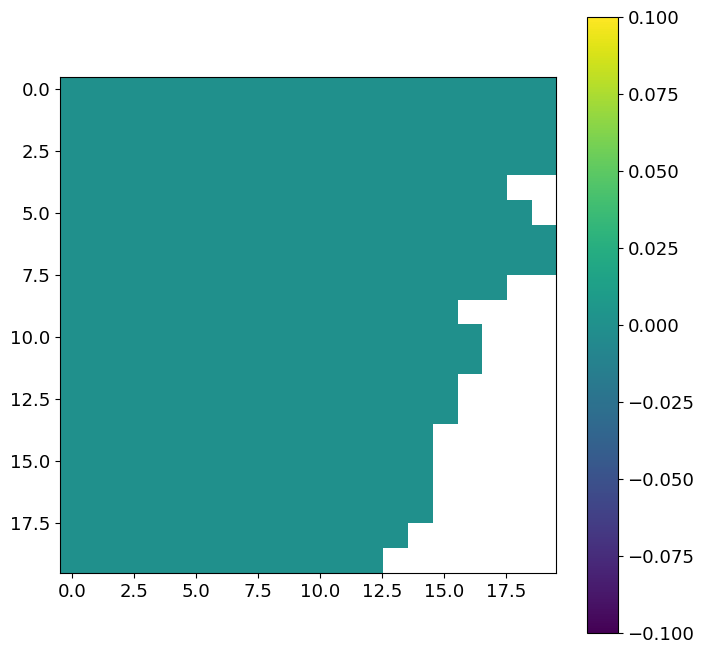

E8 - Loss: -0.8323462605476379


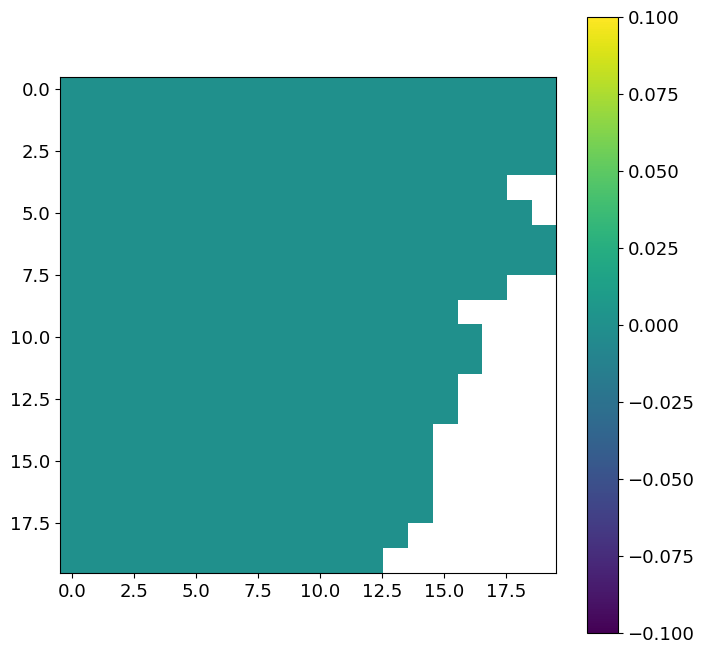

E9 - Loss: -0.9051682353019714


KeyboardInterrupt: 

In [25]:
# Creation of the dataloader
BSD_loader = BlackSea_Dataloader(x = [data_temperature],
                                 y = data_oxygen,
                                 t = days_ID,
                              mesh = mesh,
                              mask = bs_mask,
                   mask_with_depth = bs_mask_with_depth,
                        bathymetry = bathy,
                        window_inp = 1,
                        window_out = 1,
                    window_transfo = 1,
                              mode = "regression")

ds_train      = BSD_loader.get_dataloader("train")
ds_validation = BSD_loader.get_dataloader("validation")
ds_test       = BSD_loader.get_dataloader("test")

# Extracting the normalized oxygen treshold value
norm_oxy = BSD_loader.get_normalized_deoxygenation_treshold()
print("Norm oxy", norm_oxy)

# Neural Network stuff
neural_network = FCNN(problem = "regression",
                      inputs  = 4,
                      outputs = 1,
                      window_transformation = 1,
                      kernel_size = 3,
                      scaling = 1)
optimizer      = optim.Adam(neural_network.parameters(), lr = 0.001)





# ------------------------------------------------
show = False

for epoch in range(10):
    metrics_tool = BlackSea_Metrics(mode = "regression",
                                    mask = bs_mask_with_depth[4:-4, 4:-4],
                            mask_complete = bs_mask_complete[ 4:-4, 4:-4],
                                treshold = norm_oxy,
                        number_of_samples = BSD_loader.get_number_of_samples("validation"))

    for x, t, y in ds_train:

        # Training
        prediction = neural_network(x, t)
        loss_training = compute_loss(y_pred = prediction, y_true = y, problem = "regression", device = "cpu", kwargs = {})
        print(f"E{epoch} - Loss:", loss_training.detach().item())
        optimizer.zero_grad()
        loss_training.backward()
        optimizer.step()
        break

    with torch.no_grad():

        for x, t, y in ds_validation:

            prediction = neural_network(x, t)
            prediction = prediction.detach()
            prediction = prediction[:, :, :, 4:-4, 4:-4]
            y          = y[:, :, :, 4:-4, 4:-4]

            # Only one validation sample to debug
            #prediction = torch.unsqueeze(prediction[1], dim = 0)
            #y = torch.unsqueeze(y[1], dim = 0)

            prediction[:,:,:,:,:] = 0
            prediction[:,:,:,0,0] = 1
            y[:,:,:,:,:] = 0
            y[:,:,:,0,0] = 1

            # Plotting mean against ground truth in a subplot
            if show:

                # Highlighting hypoxic areas
                y_hyp = ( y < norm_oxy ) * 1.0
                p_hyp = ( prediction < norm_oxy ) * 1.0

                # Hiding non-obserable areas
                p_hyp[:,:,:, y[0, 0, 0] == -1] = torch.nan
                y_hyp[:,:,:, y[0, 0, 0] == -1] = torch.nan

                print("\n")
                print("GT - Hypoxia",        torch.nanmean(y_hyp))
                print("GT - Oxygenated", 1 - torch.nanmean(y_hyp))
                print("PR - Hypoxia",        torch.nanmean(p_hyp))
                print("PR - Oxygenated", 1 - torch.nanmean(p_hyp))

                plt.figure(figsize = (5, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(torch.flipud(y_hyp[0, 0, 0]))
                plt.subplot(1, 3, 2)
                plt.imshow(torch.flipud(p_hyp[0, 0, 0]))
                plt.subplot(1, 3, 3)
                plt.imshow(torch.flipud(y_hyp[0, 0, 0]) - torch.flipud(p_hyp[0, 0, 0]))
                plt.setp(plt.gcf().get_axes(), xticks = [], yticks = [])
                plt.subplot(1, 3, 1).set_title("Ground Truth", fontsize = 6)
                plt.subplot(1, 3, 2).set_title("Prediction", fontsize = 6)
                plt.subplot(1, 3, 3).set_title("Difference", fontsize = 6)
                plt.show()

                prediction[:,:,:, y[0,0,0,:,:] == -1] = torch.nan
                y[:,:,:, y[0,0,0,:,:] == -1] = torch.nan

                plt.figure(figsize = (8, 8))
                plt.subplot(1, 3, 1)
                plt.imshow(torch.flipud(y[0, 0, 0]),  vmin = 0, vmax = 1)
                plt.subplot(1, 3, 2)
                plt.imshow(torch.flipud(prediction[0, 0, 0]), vmin = 0, vmax = 1)
                plt.subplot(1, 3, 3)
                plt.imshow(torch.flipud(torch.sqrt(torch.exp(prediction[0, 0, 1]))), vmin = 0, vmax = 1)
                plt.setp(plt.gcf().get_axes(), xticks = [], yticks = [])
                plt.subplot(1, 3, 1).set_title("Ground Truth", fontsize = 6)
                plt.subplot(1, 3, 2).set_title("Prediction (Mean)", fontsize = 6)
                plt.subplot(1, 3, 3).set_title("Prediction (Std)", fontsize = 6)
                plt.show()

            # Testing metrics
            metrics_tool.compute_metrics(y_pred = prediction, y_true = y)
            #metrics_tool.compute_plots(  y_pred = prediction, y_true = y)

        # Getting the results

        if show:
            results, results_name = metrics_tool.get_results()
            for r, n in zip(results[0], results_name):
                print(n, " : ", r)
            print("\n")

        #metrics_tool.compute_plots_comparison_regression(y_pred = prediction, y_true = y)
        #fp, tp, auc, auc_plot  = metrics_tool.compute_plot_ROCAUC_global(y_pred = prediction, y_true = y, normalized_threshold = norm_oxy)
        auc_plot_local = metrics_tool.compute_plot_ROCAUC_local(y_pred = prediction, y_true = y, normalized_threshold = norm_oxy)



        # Computing global ROCAUC
        # fp, tp, auc, auc_plot  = metrics_tool.compute_plot_ROCAUC_global(y_pred = torch.unsqueeze(prediction[:, :, 0], dim = 1), y_true = y, normalized_threshold = 0.1)
        # auc_plot_local = metrics_tool.compute_plot_ROCAUC_local( y_pred = torch.unsqueeze(prediction[:, :, 0], dim = 1), y_true = y, normalized_threshold = 0.1)
        #metrics_tool.compute_plots_comparison_regression(y_pred = prediction, y_true = y)
        #metrics_tool.compute_plots_comparison_classification(y_pred = prediction, y_true = y)

In [ ]:
plt.imshow(bs_mask_complete)
plt.colorbar()

In [ ]:
print(fp)
081332310

332300
